# Variant Analysis Project
**Author:** A Manning Smith

## Project Description
Here

In [100]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
from matplotlib.font_manager import FontProperties
import seaborn as sns
import openpyxl
import requests
import time

# Read Data (text file)
#rawVaris = pd.read_csv('genome_hu0B4CF6_out.txt', sep='\t', header=0 , encoding='utf-8')

# Save to pkl
#rawVaris.to_pickle('genome_hu0B4CF6_out.pkl')

# Read Data (pkl file)
rawVaris = pd.read_pickle('genome_hu0B4CF6_out.pkl')

# Read Selected Variants
selectedVaris = pd.read_csv('selectedVariants.txt', sep='\t', header=0 , encoding='utf-8')

In [ ]:
# Get Pripority Variants
rawVaris['granthamScore'] = pd.to_numeric(rawVaris['granthamScore'], errors='coerce')
rawVaris['scoreCADD'] = pd.to_numeric(rawVaris['scoreCADD'], errors='coerce')
rawVaris['polyPhen'] = pd.to_numeric(rawVaris['polyPhen'], errors='coerce')

high_impact = rawVaris[(rawVaris['functionGVS'] == 'missense') & 
                       (rawVaris['granthamScore'] > 100) &
                          (rawVaris['scoreCADD'] > 20) &
                            (rawVaris['polyPhen'] > 0.85)
                       ]

priority_variants = pd.concat([high_impact]).drop_duplicates()

# Save to Excel
#priority_variants.to_excel('priority_variants.xlsx', index=False)

In [42]:
## Summary Statistics

df = rawVaris.copy() # Make a copy to avoid modifying the original data

total_variants = len(df) # Get the total number of variants
    
# Replace 'unknown' with NaN for the three score columns
score_columns = ['polyPhen', 'granthamScore', 'scoreCADD']
for col in score_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, non-numeric becomes NaN


valid_counts = df[score_columns].count() # Count the number of valid observations for each score
dropped_counts = total_variants - valid_counts # Calculate the number of dropped observations for each score
complete_cases = df.dropna(subset=score_columns) # Filter out rows where any of the scores are NaN
total_removed = total_variants - len(complete_cases) # Count how many observations were removed
n_complete_cases = len(complete_cases) # Count the number of complete cases


# Calculate summary statistics for each score
summary_stats = {}
for col in score_columns:
    stats = df[col].describe()
    summary_stats[col] = {
        'Min': stats['min'],
        'Max': stats['max'],
        'Mean': stats['mean'],
        'Median': stats['50%'],
        'Std Dev': stats['std'],
        'Top 75%': stats['75%'],
        'Valid Obs.': valid_counts[col],
        'Missing': dropped_counts[col]
    }

stats = complete_cases['scoreCADD'].describe()
summary_stats['scoreCADD_complete'] = {
    'Min': stats['min'],
    'Max': stats['max'],
    'Mean': stats['mean'],
    'Median': stats['50%'],
    'Std Dev': stats['std'],
    'Top 75%': stats['75%'],
    'Valid Obs.': n_complete_cases,
    'Missing': total_variants - n_complete_cases
}

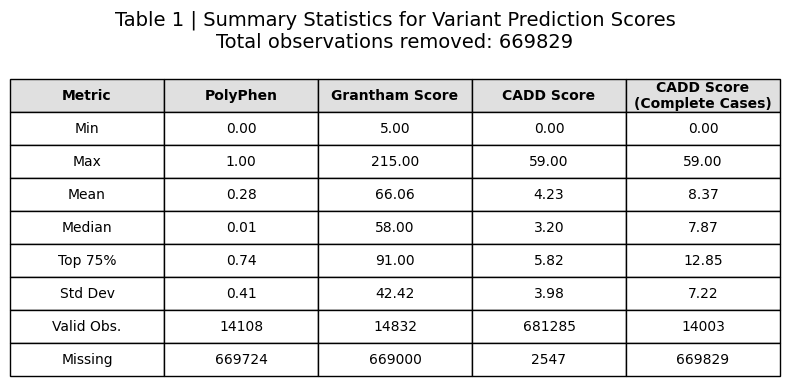

In [75]:
# Create a figure for the table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')

# Prepare data for the table
table_data = []
metrics = ['Min', 'Max', 'Mean', 'Median','Top 75%', 'Std Dev', 'Valid Obs.', 'Missing']

# Add rows for each metric
for metric in metrics:
    row = [metric]
    for score in ['polyPhen', 'granthamScore', 'scoreCADD', 'scoreCADD_complete']:
        value = summary_stats[score][metric]
        # Format numbers nicely
        if metric in ['Valid Obs.', 'Missing']:
            row.append(f"{value:.0f}")
        else:
            row.append(f"{value:.2f}")
    table_data.append(row)

# Create the table
the_table = ax.table(
    cellText=table_data,
    colLabels=['Metric', 'PolyPhen', 'Grantham Score', 'CADD Score', 'CADD Score\n(Complete Cases)'],
    loc='center',
    cellLoc='center'
)

# Style the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 2)

# Style the header row - fixed to color all header cells
for j in range(5):  # 5 columns total
    the_table[(0, j)].set_facecolor('#E0E0E0')
    the_table[(0, j)].set_text_props(weight='bold')

plt.title(f'Table 1 | Summary Statistics for Variant Prediction Scores\nTotal observations removed: {total_removed}', 
            fontsize=14, pad=20)

plt.tight_layout()

# Save the table figure
fig.savefig('figures/t1_scores_summary.png', dpi=300, bbox_inches='tight')

C:\Users\manni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\manni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\manni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


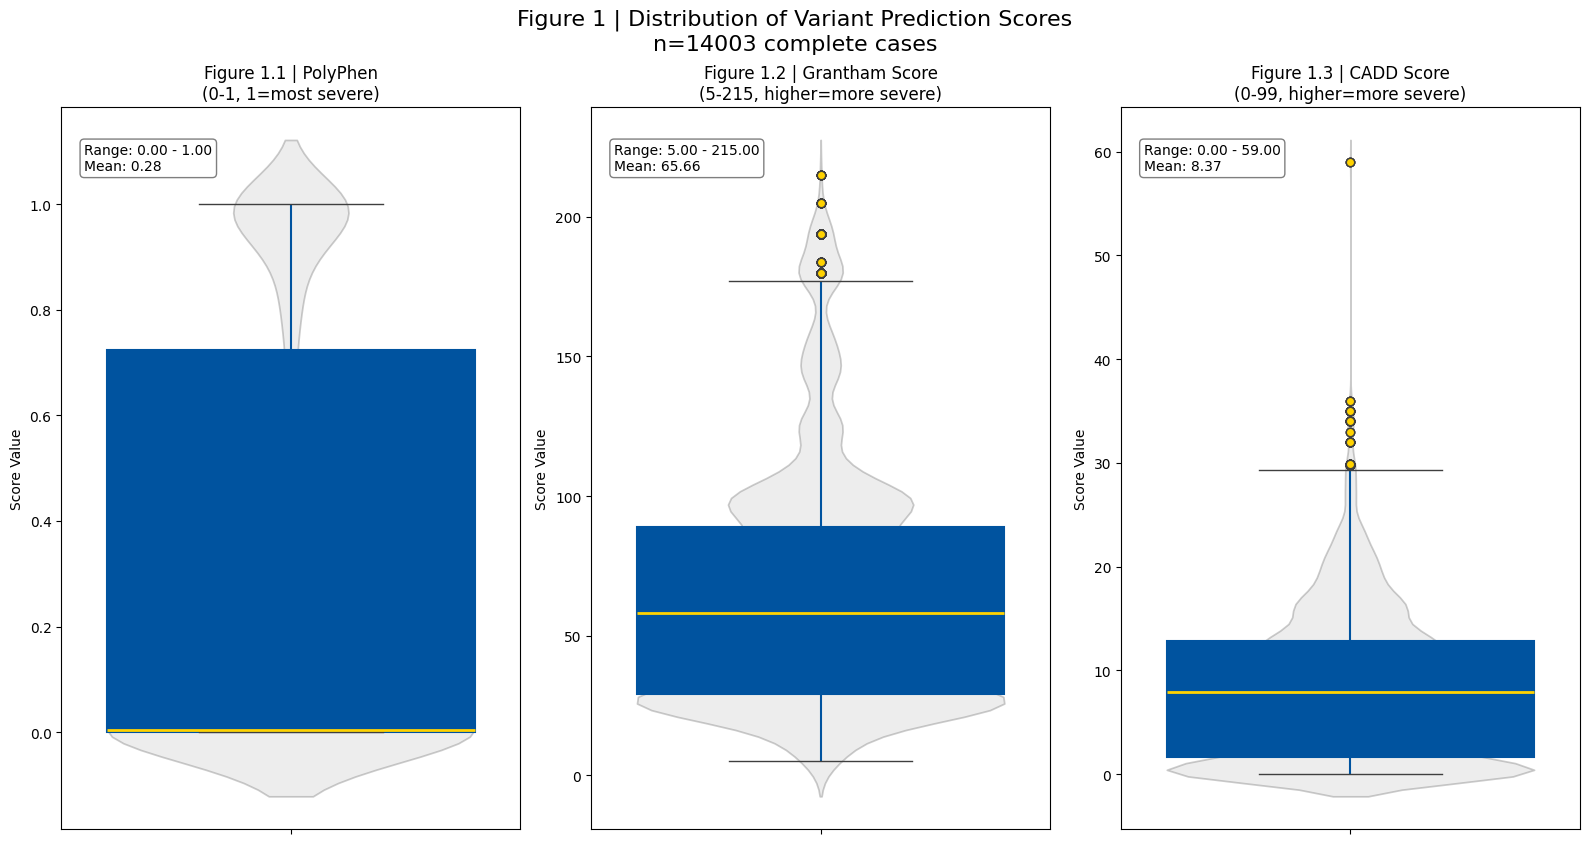

In [72]:
# Create a figure for the box plots
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

# Customize box plot appearance
boxprops = dict(linestyle='-', linewidth=1.5, color='#00539F')
flierprops = dict(marker='o', markerfacecolor='#FFD200', markersize=6)
whiskerprops = dict(linestyle='-', linewidth=1.5, color='#00539F')
medianprops = dict(linestyle='-', linewidth=2, color='#FFD200')


# Draw each box plot
score_info = [
    ('polyPhen', 'Figure 1.1 | PolyPhen\n(0-1, 1=most severe)'),
    ('granthamScore', 'Figure 1.2 | Grantham Score\n(5-215, higher=more severe)'),
    ('scoreCADD', 'Figure 1.3 | CADD Score\n(0-99, higher=more severe)')
]

for i, (col, label) in enumerate(score_info):
    # Create box plot
    sns.boxplot(y=complete_cases[col], ax=axes[i], boxprops=boxprops, 
                flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops)
    
    # Add a thin violin plot to show distribution
    sns.violinplot(y=complete_cases[col], ax=axes[i], color="lightgrey", alpha=0.4, inner=None)
    
    # Set labels and titles
    axes[i].set_title(label, fontsize=12)
    axes[i].set_ylabel('Score Value')
    
    # Add the score range as text in the plot
    score_min = complete_cases[col].min()
    score_max = complete_cases[col].max()
    score_mean = complete_cases[col].mean()
    
    textstr = f'Range: {score_min:.2f} - {score_max:.2f}\nMean: {score_mean:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

plt.tight_layout()
title = 'Figure 1 | Distribution of Variant Prediction Scores\n'
title += f'n={n_complete_cases} complete cases'
plt.suptitle(title, fontsize=16, y=1.05)

# Save the table figure
fig.savefig('figures/f1_variant_distributions.png', dpi=300, bbox_inches='tight')

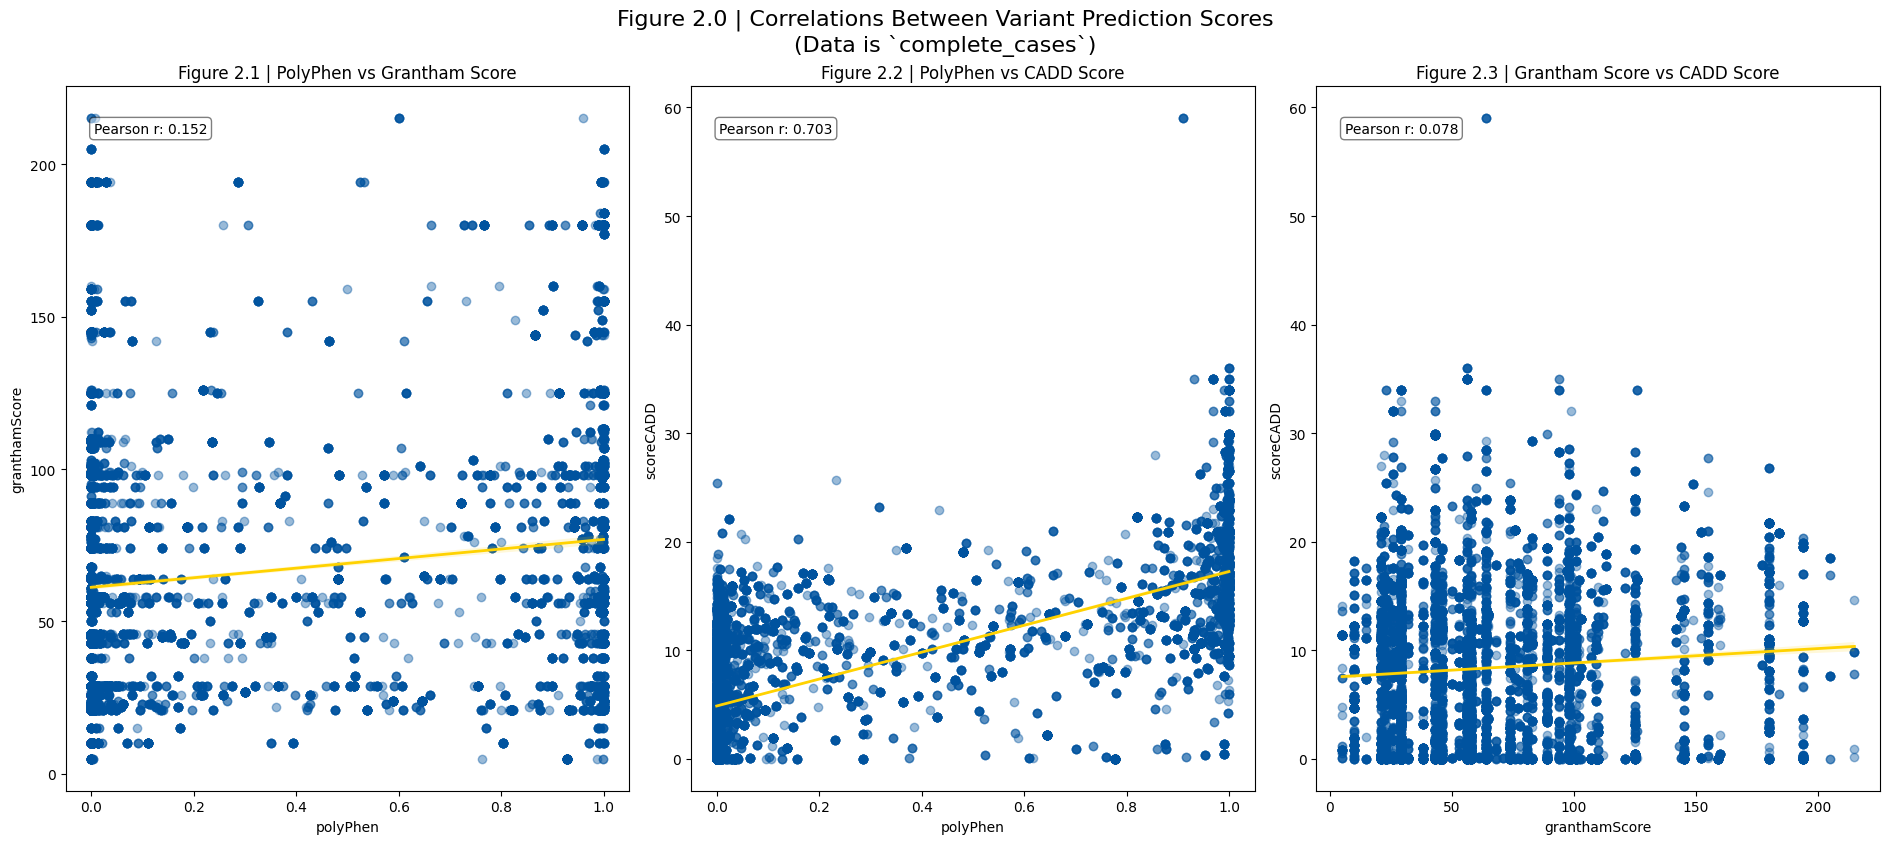

In [71]:
 # Create correlation matrix
corr_matrix = complete_cases[['polyPhen', 'granthamScore', 'scoreCADD']].corr()

# Create a figure for correlation analysis
fig, axes = plt.subplots(1, 3, figsize=(19, 8))

# Create scatter plots for each pair of scores
pairs = [
    ('polyPhen', 'granthamScore', 'Figure 2.1 | PolyPhen vs Grantham Score'),
    ('polyPhen', 'scoreCADD', 'Figure 2.2 | PolyPhen vs CADD Score'),
    ('granthamScore', 'scoreCADD', 'Figure 2.3 | Grantham Score vs CADD Score')
]

for i, (x, y, title) in enumerate(pairs):
    # Create scatter plot with regression line
    sns.regplot(x=complete_cases[x], y=complete_cases[y], ax=axes[i], 
                scatter_kws={'alpha':0.4, 'color':'#00539F'}, line_kws={'color':'#FFD200', 'linewidth': 2})
    
    # Add correlation coefficient as text
    corr = corr_matrix.loc[x, y]
    textstr = f'Pearson r: {corr:.3f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    
    # Set labels and title
    axes[i].set_title(title, fontsize=12)

plt.tight_layout()
plt.suptitle('Figure 2.0 | Correlations Between Variant Prediction Scores\n(Data is `complete_cases`)', fontsize=16, y=1.05)

# Save the table figure
fig.savefig('figures/f2_score_correlations.png', dpi=300, bbox_inches='tight')

## Gene Search & Variant Search

[AI Source](https://claude.ai/share/c65847ac-89d9-4dc0-ae30-8c8f3337cfaf). Clause was utilzied to optimzie the basic information of a list of genes to allow for further research. Clause was prompted with:
```
Research the following gene list. I want the link to the uniport entry for human. I want the gene name and the description of the gene. Save the information in a dictionary with the gene as the key. The write the python code to loop through the dictionary and save the results in an excel file.

The columns should be gen_symbol, gene_name, gene_description, uniport link.

I then want another lookup to get a excel of all the variant information on a gene. This output should be gene_symbol, ID, position, description with the rs from the dbSNP.
```
The provide code was directly used with no edits via the author. The author validated the results to ensure accuracy. There is no impact to the analysis or manucript of the paper as the results were used for further research. This code saved the user 2+ hours of data mining through UniProt.

In [ ]:
# Gene Search
def get_uniprot_info(gene_symbols):
    """
    Retrieves gene information from UniProt for a list of gene symbols.
    
    Args:
        gene_symbols (list): List of gene symbols to look up
        
    Returns:
        dict: Dictionary with gene symbols as keys and gene information as values
    """
    gene_info = {}
    
    for gene in gene_symbols:
        # Search UniProt for the human gene
        search_url = f"https://rest.uniprot.org/uniprotkb/search?query=gene:{gene}+AND+organism_id:9606&format=json"
        response = requests.get(search_url)
        
        if response.status_code == 200:
            data = response.json()
            
            # Check if we found any results
            if data['results']:
                # Get the first (most relevant) result
                entry = data['results'][0]
                uniprot_id = entry['primaryAccession']
                uniprot_link = f"https://www.uniprot.org/uniprotkb/{uniprot_id}"
                
                # Get gene name
                gene_name = gene  # Default to symbol if full name not found
                for gene_data in entry.get('genes', []):
                    if 'geneName' in gene_data:
                        gene_name = gene_data['geneName'].get('value', gene)
                
                # Get gene description/function
                description = "No description available"
                for comment in entry.get('comments', []):
                    if comment.get('commentType') == 'FUNCTION':
                        description = comment.get('texts', [{}])[0].get('value', "No description available")
                        break
                
                # Store the information
                gene_info[gene] = {
                    'gene_symbol': gene,
                    'gene_name': gene_name,
                    'gene_description': description,
                    'uniprot_link': uniprot_link
                }
            else:
                gene_info[gene] = {
                    'gene_symbol': gene,
                    'gene_name': f"No entry found for {gene}",
                    'gene_description': "Not available",
                    'uniprot_link': "Not available"
                }
        else:
            print(f"Error retrieving information for {gene}: {response.status_code}")
            gene_info[gene] = {
                'gene_symbol': gene,
                'gene_name': "Error retrieving data",
                'gene_description': "Not available",
                'uniprot_link': "Not available"
            }
        
        # Be kind to the API with a small delay
        time.sleep(1)
    
    return gene_info

def save_gene_info_to_excel(gene_info, output_file="gene_information.xlsx"):
    """
    Saves gene information to an Excel file.
    
    Args:
        gene_info (dict): Dictionary with gene information
        output_file (str): Name of the output Excel file
    """
    # Convert dictionary to DataFrame
    data = []
    for gene, info in gene_info.items():
        data.append(info)
    
    df = pd.DataFrame(data)
    
    # Ensure columns are in the correct order
    df = df[['gene_symbol', 'gene_name', 'gene_description', 'uniprot_link']]
    
    # Save to Excel
    df.to_excel(output_file, index=False)
    print(f"Gene information saved to {output_file}")

# Variant Lookup
def get_dbsnp_variants(gene_symbols, max_variants=50):
    """
    Retrieves variant information from dbSNP for a list of gene symbols.
    
    Args:
        gene_symbols (list): List of gene symbols to look up
        max_variants (int): Maximum number of variants to retrieve per gene
        
    Returns:
        dict: Dictionary with gene symbols as keys and lists of variant information as values
    """
    variant_info = {}
    
    for gene in gene_symbols:
        # Search dbSNP for variants of this gene
        search_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=snp&term={gene}[Gene+Name]+AND+human[Organism]&retmode=json&retmax={max_variants}"
        response = requests.get(search_url)
        
        if response.status_code == 200:
            data = response.json()
            variant_ids = data.get('esearchresult', {}).get('idlist', [])
            
            if variant_ids:
                # Get details for each variant
                variants_list = []
                
                # Process in batches to avoid overloading the API
                batch_size = 10
                for i in range(0, len(variant_ids), batch_size):
                    batch = variant_ids[i:i+batch_size]
                    id_string = ','.join(batch)
                    
                    fetch_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=snp&id={id_string}&retmode=json"
                    fetch_response = requests.get(fetch_url)
                    
                    if fetch_response.status_code == 200:
                        fetch_data = fetch_response.json()
                        for var_id in batch:
                            if var_id in fetch_data.get('result', {}):
                                var_data = fetch_data['result'][var_id]
                                
                                # Extract relevant information
                                rs_id = f"rs{var_id}"
                                position = var_data.get('chrpos', 'Unknown')
                                description = var_data.get('docsum', 'No description available')
                                
                                variants_list.append({
                                    'gene_symbol': gene,
                                    'ID': rs_id,
                                    'position': position,
                                    'description': description
                                })
                    else:
                        print(f"Error fetching variant details for {gene}: {fetch_response.status_code}")
                    
                    # Be kind to the API
                    time.sleep(1)
                
                variant_info[gene] = variants_list
            else:
                print(f"No variants found for {gene}")
                variant_info[gene] = [{
                    'gene_symbol': gene,
                    'ID': 'No variants found',
                    'position': 'N/A',
                    'description': 'N/A'
                }]
        else:
            print(f"Error searching variants for {gene}: {response.status_code}")
            variant_info[gene] = [{
                'gene_symbol': gene,
                'ID': 'Error retrieving data',
                'position': 'N/A',
                'description': 'N/A'
            }]
        
        # Be kind to the API
        time.sleep(1)
    
    return variant_info

def save_variant_info_to_excel(variant_info, output_file="gene_variants.xlsx"):
    """
    Saves variant information to an Excel file.
    
    Args:
        variant_info (dict): Dictionary with variant information
        output_file (str): Name of the output Excel file
    """
    # Convert dictionary to DataFrame
    data = []
    for gene, variants in variant_info.items():
        data.extend(variants)
    
    df = pd.DataFrame(data)
    
    # Ensure columns are in the correct order
    df = df[['gene_symbol', 'ID', 'position', 'description']]
    
    # Save to Excel
    df.to_excel(output_file, index=False)
    print(f"Variant information saved to {output_file}")

Gene information saved to gene_information.xlsx


In [64]:
if __name__ == "__main__":
    # Replace this with your actual gene list
    my_genes = [
    "CACNA1A", "ATM", "RAPSN", "GALNTL5", "PRKRA", "ADD1", "CHROMR", 
    "INMT", "INMT-MINDY4", "UBXN11", "PATJ", "NEXN", "FMO2", "PLXNB1", 
    "BMP2K", "NOTCH4", "SYNE1", "GAL3ST4", "CPA6", "WDR31", "CHMP4A", 
    "GSTZ1", "DUS2", "SERPINB11", "APC2", "ZNF229", "MYO18B"
    ]

    # Get gene information
    #gene_information = get_uniprot_info(my_genes)
    
    # Save to Excel
    #save_gene_info_to_excel(gene_information)
    
    # Get variant information
    variant_information = get_dbsnp_variants(my_genes)
    
    # Save to Excel
    save_variant_info_to_excel(variant_information)

Variant information saved to gene_variants.xlsx


## Get Selected Variants

In [ ]:
# Select Variants
my_genes = ["GALNTL5", "ADD1", "PRKRA,CHROMR"]
# Subset columns
filtered_variants = selectedVaris[['Variant', 'accession', 'chromosome', 'position', 'rsID', 'sampleAlleles', 'geneList']]
filtered_variants = filtered_variants[filtered_variants['geneList'].isin(my_genes)]

# Rename columns for clarity
filtered_variants = filtered_variants.rename(columns={
    'accession': 'Accession',
    'chromosome': 'Chromosome',
    'position': 'Position',
    'rsID': 'rsID',
    'sampleAlleles': 'Sample Alleles',
    'geneList': 'Gene List'
})

# Define column headers
column_labels = filtered_variants.columns.tolist()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 2))

# Turn off axis
ax.axis('off')
ax.axis('tight')

# Create the table and add it to the axis
table = ax.table(cellText=filtered_variants.values,  # Fixed: Use .values to extract numpy array
                 colLabels=column_labels,
                 loc='center',
                 cellLoc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  # Adjust scaling for better appearance

# Style header row
for i in range(len(column_labels)):
    cell = table[(0, i)]
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    cell.set_facecolor('#E0E0E0')  # Light gray background for header

# Adjust table position in figure
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Add title
plt.suptitle('Table 2 | Selected Genetic Variants', fontsize=16, y=0.98)

# Save the table as an image
plt.savefig('figures/t2_selected_variants.png', dpi=300, bbox_inches='tight')
plt.close()

In [125]:
# Select Variants
my_genes = ["GALNTL5", "ADD1", "PRKRA,CHROMR"]
# Subset columns
filtered_variants = selectedVaris[selectedVaris['geneList'].isin(my_genes)]
filtered_variants = filtered_variants[['Variant', 'polyPhen', 'granthamScore', 'scoreCADD', 'consScoreGERP']]

# Rename columns for clarity
filtered_variants = filtered_variants.rename(columns={
    'polyPhen': 'PolyPhen',
    'granthamScore': 'Grantham Score',
    'scoreCADD': 'CADD Score',
    'consScoreGERP': 'GREP Score'
})

column_labels = ['Variant', 'PolyPhen', 'Grantham Score', 'CADD Score', 'GREP Score']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Turn off axis
ax.axis('off')
ax.axis('tight')

# Create the table and add it to the axis
table = ax.table(cellText=filtered_variants.values,
                 colLabels=column_labels,
                 loc='center',
                 cellLoc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Style header row
for i in range(len(column_labels)):
    cell = table[(0, i)]
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    cell.set_facecolor('#E0E0E0')

# Adjust table position in figure
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Add title
plt.suptitle('Table 3 | Variant Prediction Scores', fontsize=16, y=0.98)

# Save the table as an image
plt.savefig('figures/t3_variant_scores.png', dpi=300, bbox_inches='tight')
plt.close()
